# Construction and validation of bioNLP named entity recognition model using deep learning
Problems: the embeddings I trained is worse than the one from google

deep_nlp_serial

Attribution: 
    Some of the code are borrowed from the example code from spacy

In [1]:
import tensorflow
from tqdm import tqdm

import keras
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pathlib
import cytoolz
import numpy
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
import thinc.extra.datasets
from spacy.compat import pickle
import spacy
import pandas as pd
from sklearn import preprocessing
import keras
from sklearn import model_selection
#import seaborn as sns
from sklearn import metrics
#import matplotlib.pyplot as plt

Using TensorFlow backend.
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### load in SRA data

Wall time: 47.5 s


In [2]:
%%time 
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'
sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'
srsS=pd.read_pickle(inS_dir)
technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)


CPU times: user 10.8 s, sys: 3.74 s, total: 14.6 s
Wall time: 15.6 s


In [3]:
technical_meta_data_df=technical_meta_data_df.sample(technical_meta_data_df.shape[0])

### load in spacy models

Wall time: 52.1 s


In [4]:
%%time
#nlp=spacy.load('en_vectors_web_lg')
nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


CPU times: user 49.9 s, sys: 5.2 s, total: 55.1 s
Wall time: 55 s


### Functions for model compilation and feature extraction

Useful information for understanding the neural network: 

TimeDistributed: https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

lr stands for: learning rate

In [5]:
def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape['max_length'],
            trainable=False,
            weights=[embeddings],
            mask_zero=True
        )
    )
    #the same dense layer is first applied extract the most useful info from embedding layers
    model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
    model.add(Bidirectional(LSTM(shape['nr_hidden'],
                                 recurrent_dropout=settings['dropout'],
                                 dropout=settings['dropout'])))
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='categorical_crossentropy',
		  metrics=['accuracy'])
    return model

def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in tqdm(enumerate(docs),total=len(docs)):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

# subset sra data 

In [6]:
srsWithText=srsS.index.get_level_values(0).unique()

In [7]:
technical_meta_data_df_sub=technical_meta_data_df[technical_meta_data_df.Sample.isin(srsWithText)]

### subset data based on entity types grouped by word vectors

In [8]:
grouping_df=pd.read_csv('./Results/grouping.csv')

In [9]:
##attributes, original attributes from NCBI
grouping_df.head(n=15)

,Unnamed: 0,GroupName,I,Attributes,cosine,VC
0,0,Species,0,SCIENTIFIC_NAME,1.000000,1136856
1,1,Species,1,organism,0.975771,29037
2,2,Species,2,Organism,0.947185,2894
3,3,Species,3,host,0.911220,205511
4,4,Species,4,host scientific name,0.910215,9909
5,5,Species,5,host organism,0.886798,372
6,6,Species,6,Species,0.879431,578
7,7,Species,7,specific host,0.877695,11114
8,8,Species,8,nat-host,0.869496,1516
9,9,Species,9,specific_host,0.827073,14088


### cap contribution by each study

In [10]:
max_sample_per_study_n=100

In [11]:
myAttribs=grouping_df.Attributes.unique()

In [12]:
subsampledSrs=technical_meta_data_df.groupby('Study').head(n=max_sample_per_study_n)['Sample']
print ('classify: {}'.format(", ".join(myAttribs)))
m=srsS.index.get_level_values(0).isin(subsampledSrs.values)
m1=srsS.index.get_level_values(1).isin(myAttribs)
srsS_subS=srsS[m&m1]

classify: SCIENTIFIC_NAME, organism, Organism, host, host scientific name, host organism, Species, specific host, nat-host, specific_host, host_scientific_name, genotype, genotype/variation, mutant, mutation, Genotype, host genotype, host_genotype, ArrayExpress-Genotype, plant genotype, disease, disease state, tumor type, DiseaseState, disease status, histology, cancer type, diagnosis, clinical history, cell description, tumor, cell type, cell_type, source cell type, cell types, progenitor cell type, CellType, cell-type, tissue/cell type, DIFFERENTIATION_STAGE, biomaterial_type, source_name, cell subtype, cell, differentiation status, cell line source, tissue, tissue_type, organ, tissue source, tissue-type, organism part, Tissue, ArrayExpress-OrganismPart, tissue type, tissue origin, geo_loc_name, geographic location, geographic location (country and/or sea, region), geo loc name, "geographic location (country and/or sea,region)", country, geographic location (country and/or sea,region

In [13]:
srsS_subS.head()

SRS1024493  SCIENTIFIC_NAME                  Camellia oleifera
            geo_loc_name       China: 856 m, Jinggang Mountain
            tissue                                        Leaf
SRS568274   SCIENTIFIC_NAME    Escherichia coli 2-316-03_S3_C1
            country                                   Tanzania
dtype: object

###  

### filter text with missing or unknowns

In [14]:
filterTextL=['not collected','not applicable','missing','n[/]?a','unknown']
filterTextRegex="|".join(map(lambda myStr:'(?:{})'.format(myStr),filterTextL))

In [15]:
srs_filterM=srsS_subS.str.contains(filterTextRegex,case=False)
srsS_subS=srsS_subS[~srs_filterM].str.replace( '\s+',' ')

In [16]:
word_countS=srsS_subS.str.count(' ' )+1

In [17]:
wordCount_m=(word_countS>=2)&(word_countS<=7)
myDf=srsS_subS[wordCount_m].reset_index()
myDf.columns=['srs','attrib','sentence']

remove _ which is often used for spacing as opposed to space

In [18]:
myDf['sentence']=myDf['sentence'].str.replace('_',' ')

# split data into training and  testing randomly by study levels

It is split by study level to avoid overgeneralization

In [19]:
train_test_ratio=0.8

In [20]:
study_S=technical_meta_data_df_sub['Study'].drop_duplicates()
print (len(study_S))
myNStudies=len(study_S)
train_n=int((myNStudies*train_test_ratio))
train_studies=study_S.sample(n=train_n,random_state=0).values
technical_meta_data_df_sub['Train']=technical_meta_data_df_sub['Study'].isin(train_studies).values

106722


/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


slice out the training and testing SRS ids

In [21]:
train_mask=technical_meta_data_df_sub['Train']
train_samples=technical_meta_data_df_sub['Sample'][train_mask].values
test_samples=technical_meta_data_df_sub['Sample'][~train_mask].values

### rename the attrib based on the grouped class name

In [22]:
myDf['orig_attrib']=myDf['attrib']
AttribToGroupNameS=grouping_df.groupby('Attributes')['GroupName'].first()
myDf['attrib']=AttribToGroupNameS[myDf['orig_attrib'].values].values

In [23]:
### set training and testing within the dataframe
all_train_df=myDf[myDf.srs.isin(train_samples)]
g=all_train_df.groupby('attrib')
print (g.size())

attrib
Cell type/tissue            311281
Disease state                12589
Genotype                     41426
Geographical Location       151138
Species                     969221
Treatment and conditions     29323
dtype: int64


In [24]:
all_train_df

,srs,attrib,sentence,orig_attrib
0,SRS1024493,Species,Camellia oleifera,SCIENTIFIC_NAME
1,SRS568274,Species,Escherichia coli 2-316-03 S3 C1,SCIENTIFIC_NAME
2,SRS568274,Species,Homo sapiens,nat-host
4,ERS949109,Species,Mus musculus,SCIENTIFIC_NAME
5,SRS1158727,Species,Homo sapiens,SCIENTIFIC_NAME
6,SRS1158727,Cell type/tissue,MCF7 breast cancer cell line,source_name
7,SRS1158728,Species,Homo sapiens,SCIENTIFIC_NAME
8,SRS1158728,Cell type/tissue,normal breast epithelial cells,source_name
9,SRS1158729,Species,Homo sapiens,SCIENTIFIC_NAME
10,SRS1158729,Cell type/tissue,normal breast epithelial cells,source_name


### filter based on data availability

### cap on text duplicates

In [25]:
nDupTextMax=1000

In [26]:
all_train_df=all_train_df.sample(all_train_df.shape[0])

In [27]:
categorical_fields=['SCIENTIFIC_NAME']
dedup_train_df=all_train_df[~all_train_df.orig_attrib.isin(['SCIENTIFIC_NAME'])
                           ].groupby(['sentence']).head(n=nDupTextMax)

### subsetting training and testing data 
shuffle the training data to make sure the model isn't learning the ordering of the data

In [28]:
cap_size=20000#20000#1000#50000
train_df=dedup_train_df.sample(dedup_train_df.shape[0]).groupby('attrib').head(n=cap_size)
all_test_df=myDf[myDf.srs.isin(test_samples)]
test_df=all_test_df.sample(n=all_test_df.shape[0]).groupby('attrib').head(cap_size)

### set up LSTM model

In [29]:
nr_hidden=64 
max_length=7#, #95% percentile of training phrase length from NCIT
dropout=0.5
learn_rate=0.001#, # General NN config
nb_epoch=1#
batch_size=100

use the sklearn encoder going back and forth between classes in string format and integer format

In [30]:
classNames=AttribToGroupNameS.unique()

In [31]:
le = preprocessing.LabelEncoder()
le.fit(classNames)
nr_classes=len(le.classes_)

In [32]:
lstm_shape={'nr_hidden': 64, 'max_length': max_length, 'nr_class': nr_classes}
lstm_settings={'dropout': 0.5, 'lr': 0.001}

In [33]:
embeddings = nlp.vocab.vectors.data

### transform list of freetexts into a matrix of word embeddings

In [34]:
train_df.attrib.value_counts()

Treatment and conditions    20000
Genotype                    20000
Cell type/tissue            20000
Species                     20000
Geographical Location       20000
Disease state               12578
Name: attrib, dtype: int64

In [35]:
test_df.attrib.value_counts()

Cell type/tissue            20000
Species                     20000
Geographical Location       20000
Genotype                     9882
Treatment and conditions     7375
Disease state                2978
Name: attrib, dtype: int64

In [36]:
train_texts=train_df.sentence.tolist()
dev_texts=test_df.sentence.tolist()

train_labels=keras.utils.to_categorical(
    le.transform(train_df.attrib.values))
dev_labels=keras.utils.to_categorical(le.transform(test_df.attrib.values))

train_docs = list(tqdm(nlp.pipe(train_texts,n_threads=32),total=len(train_texts)))
dev_docs = list(tqdm(nlp.pipe(dev_texts,n_threads=32),total=len(dev_texts)))

train_X = get_features(train_docs, lstm_shape['max_length'])
dev_X = get_features(dev_docs, lstm_shape['max_length'])

100%|██████████| 80235/80235 [00:00<00:00, 159330.46it/s]


#### Model training


#26 mins per epoch, on a machine with 48 threads, might want to use GPU machine bordeaux for this 


In [38]:
numpy.save('./model/classes.npy', le.classes_)

In [39]:
model = compile_lstm(embeddings, lstm_shape, lstm_settings)

In [ ]:
from IPython.utils import io

In [40]:
%%capture keras_stdout
lstm=model.fit(train_X, train_labels, validation_data=(dev_X, dev_labels),
          nb_epoch=nb_epoch,verbose=1, batch_size=batch_size)

In [41]:
lstm.model.save('./model/lstm.h5')

### see how training accuracy improve as the amount of data increase

In [42]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [43]:
keras_stdout_str=keras_stdout.stdout

In [44]:
trainingAcc=pd.Series(keras_stdout_str.split('\r')).str.replace('\x08','').str.extract('acc: (\d+.\d+)').dropna()[0].astype(float)

In [45]:
trainingAcc.index=trainingAcc.index*batch_size/1000

In [46]:
np.arange(0,0.9,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

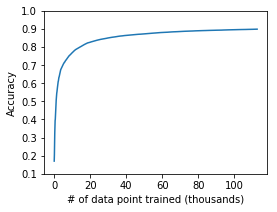

In [47]:
fig,ax=plt.subplots(figsize=(4,3))
trainingAcc.plot(ax=ax)
#ax.set_ylabel('#')
ax.set_xlabel('# of data point trained (thousands)')
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(0.1,1.1,0.1))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.figure.savefig('./Results/Figures/data_vol__accuracy.pdf')
ax.figure.savefig('./Results/Figures/data_vol__accuracy.png',dpi=300)

### evaluate model

In [48]:
from keras.models import load_model


In [49]:
val_docs = list(tqdm(nlp.pipe(dev_texts,),total=len(dev_texts)))
val_X=get_features(val_docs,lstm_shape['max_length'])
%time predictM=lstm.model.predict_proba(val_X)

100%|██████████| 80235/80235 [00:00<00:00, 160710.09it/s]


CPU times: user 6min 12s, sys: 7.97 s, total: 6min 20s
Wall time: 14.6 s


In [50]:
probaDf_multI=pd.DataFrame(data=predictM,columns=le.classes_)

In [51]:
probaDf_multI.index=pd.MultiIndex.from_arrays([test_df.attrib.values,dev_texts],names=['entity','text'])

In [52]:
probaDf=probaDf_multI.reset_index()

In [53]:
myClasses=grouping_df.GroupName.unique()
predicted_types=probaDf.loc[:,probaDf.columns.isin(myClasses)].idxmax(axis=1)

In [54]:
print ('Accuracy:',((probaDf.entity==predicted_types).mean()))

Accuracy: 0.9343802579921481


### show contingency tables

In [55]:
inEvalDf=probaDf_multI#.loc[~probaDf_multI.index.get_level_values('entity').isin(['strain']),~probaDf_multI.columns.isin(['strain'])]#[m_cleanText]

In [56]:
minProbThreshold=0.2
confidence_mask=inEvalDf.max(axis=1)>=minProbThreshold
tmpDf3=inEvalDf.idxmax(axis=1).reset_index(name='predicted')

In [57]:
tmpDf3.groupby('predicted').size()

predicted
Cell type/tissue            18340
Disease state                3653
Genotype                    10455
Geographical Location       19921
Species                     20239
Treatment and conditions     7627
dtype: int64

In [58]:
continDf=tmpDf3.groupby(['predicted','entity']).size().unstack().fillna(0)

In [59]:
continDf.columns=continDf.columns.copy()

In [60]:
attribVC_train=train_df.attrib.value_counts()#.to_frame()

### plot heatmap

In [61]:
continDf=continDf.loc[attribVC_train.index,attribVC_train.index]
continDf.index=continDf.index.copy()
continDf.columns=continDf.columns.copy()
continDf.index.name='Predicted'
continDf.columns.name='Actual'
percentDf=(continDf/continDf.sum(axis=0)).T

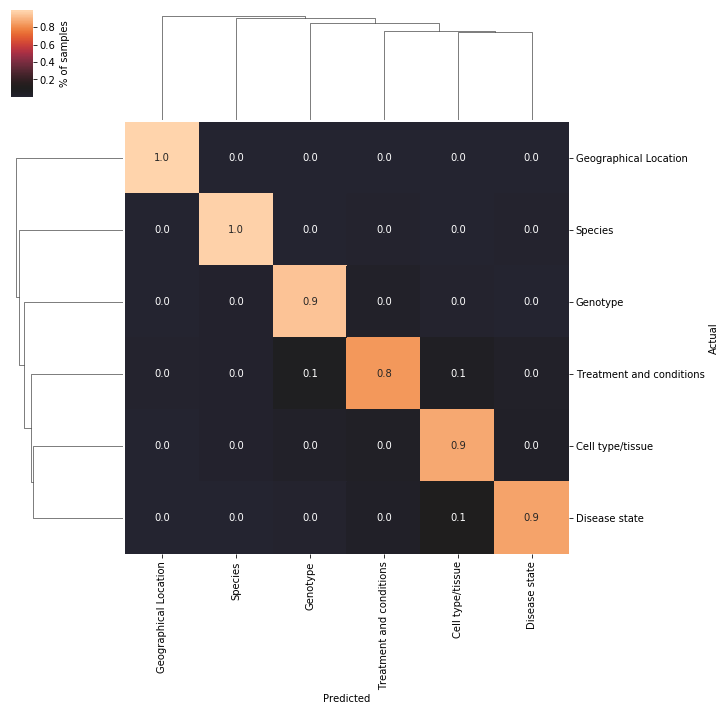

In [62]:
g=sns.clustermap(data=percentDf,annot=True,cbar_kws={'label':'% of samples'},center=0.1,
           fmt='.1f')
#plt.close()

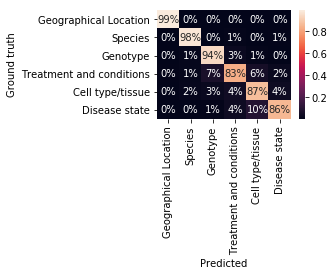

In [63]:
fig,ax=plt.subplots(figsize=(3,2))
g.data2d.columns=g.data2d.columns.copy()
g.data2d.index=g.data2d.index.copy()
#g.data2d.index.name='Actual'
sns.heatmap(data=percentDf.loc[g.data2d.columns,g.data2d.columns],annot=True,ax=ax,fmt='0.0%')
ax.set_ylabel('Ground truth')
fig.savefig('./Results/Figures/entity_contingency.pdf',bbox_inches='tight')
fig.savefig('./Results/Figures/entity_contingency.png',dpi=300,bbox_inches='tight')

In [64]:
contdf_long=percentDf.stack().reset_index(name='Percent')

In [65]:
contdf_wrong=contdf_long[contdf_long.Actual!=contdf_long.Predicted].sort_values('Percent')
contdf_wrong[contdf_wrong.Percent>5]

,Actual,Predicted,Percent


{'Cell type/tissue': 0.06417132541537285,
 'Disease state': 0.2003842331469059,
 'Genotype': 0.34683769941329956,
 'Geographical Location': 0.8460280895233154,
 'Species': 0.5533264875411987,
 'Treatment and conditions': 0.04763772338628769}

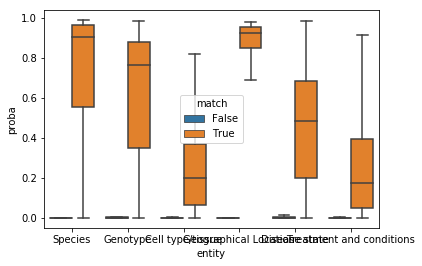

In [66]:
predDf=probaDf_multI.stack().reset_index()
predDf.columns=['entity','text','predicted','proba']
predDf['match']=predDf.entity==predDf.predicted
sns.boxplot(data=predDf,x='entity',y='proba',hue='match',showfliers=False)
predDf[predDf['match']].groupby(['entity'])['proba'].quantile(0.25).to_dict()

#### Performance of model in validation cohort

In [67]:
#!ls ./Results/Figures/

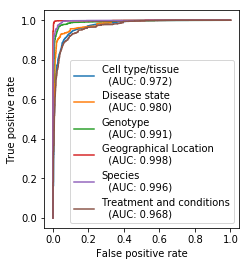

In [68]:
fig,ax=plt.subplots(figsize=(3.5,4
                            ))
for myClass in le.classes_: 
    fpr,tpr,_=metrics.roc_curve((probaDf.entity==myClass),probaDf[myClass])    
    ax.plot(fpr,tpr,label="{myClass}\n  (AUC: {AUC})".format(myClass=myClass,AUC=str(metrics.auc(fpr,tpr))[:5]))
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend()
fig.savefig('./Results/Figures/ROC.pdf',bbox_inches='tight')
fig.savefig('./Results/Figures/ROC.png',bbox_inches='tight')



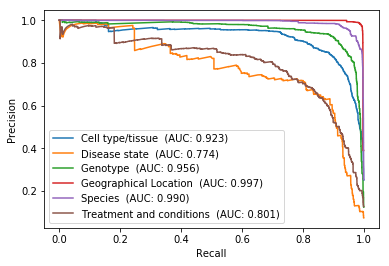

In [69]:
fig,ax=plt.subplots()
for myClass in le.classes_: 
    precision,recall,_=metrics.precision_recall_curve((probaDf.entity==myClass),probaDf[myClass])    
    ax.plot(recall, precision,label="{myClass}  (AUC: {AUC})".format(myClass=myClass,AUC=str(metrics.auc(recall,precision))[:5]))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

### entities

In [70]:
entity_a=inEvalDf.index.get_level_values('entity')

In [71]:
inTmpDf=inEvalDf.idxmax(axis=1).reset_index(name='predicted')

In [72]:
inTmpDf['correct']=inTmpDf.entity==inTmpDf.predicted

In [73]:
inTmpDf.to_csv('./model/pred.csv')

In [74]:
#Breed, SCIENTIFIC_NAME
inTmpDf.entity.value_counts()

Cell type/tissue            20000
Species                     20000
Geographical Location       20000
Genotype                     9882
Treatment and conditions     7375
Disease state                2978
Name: entity, dtype: int64

In [75]:
inTmpDf[(inTmpDf.predicted=='breed')&(inTmpDf.entity=='breed')]

,entity,text,predicted,correct


In [76]:
inTmpDf['correct'].mean()

0.9343802579921481

In [77]:
inTmpDf.groupby('entity')['correct'].mean().sort_values()

entity
Treatment and conditions    0.834305
Disease state               0.858630
Cell type/tissue            0.872900
Genotype                    0.944546
Species                     0.980800
Geographical Location       0.992600
Name: correct, dtype: float64

In [78]:
## use synapse for downloading

In [79]:
#inEvalDf[entity_a=='breed'].sort_values('breed',ascending=False).index.get_level_values('text').value_counts()

In [80]:
inEvalDf.head()

Cell type/tissue  Disease state  Genotype  \
entity  text                                                                
Species Rattus norvegicus               0.000145       0.000036  0.000069   
        Homo sapiens                    0.000290       0.000072  0.000042   
        Mus musculus                    0.000140       0.000027  0.000067   
        human oral metagenome           0.000891       0.000191  0.000023   
        Nothobranchius furzeri          0.000188       0.000010  0.002222   

                                Geographical Location   Species  \
entity  text                                                      
Species Rattus norvegicus                    0.000020  0.960126   
        Homo sapiens                         0.000024  0.964343   
        Mus musculus                         0.000015  0.932140   
        human oral metagenome                0.000011  0.507865   
        Nothobranchius furzeri               0.000011  0.213147   

                                Treatment and conditions  
entity  text                                              
Species Rattus norvegicus                       0.000108  
        Homo sapiens                            0.000064  
        Mus musculus                            0.000066  
        human oral metagenome                   0.000716  
        Nothobranchius furzeri                  0.000119

### calculated F1 score

``'binary'``:
        Only report results for the class specified by ``pos_label``.
        This is applicable only if targets (``y_{true,pred}``) are binary.
    ``'micro'``:
        Calculate metrics globally by counting the total true positives,
        false negatives and false positives.
    ``'macro'``:
        Calculate metrics for each label, and find their unweighted
        mean.  This does not take label imbalance into account.
    ``'weighted'``:
        Calculate metrics for each label, and find their average, weighted
        by support (the number of true instances for each label). This
        alters 'macro' to account for label imbalance; it can result in an
        F-score that is not between precision and recall.
    ``'samples'``:
        Calculate metrics for each instance, and find their average (only
        meaningful for multilabel classification where this differs from
        :func:`accuracy_score`).

In [81]:
print( metrics.f1_score(y_true=inTmpDf['entity'],y_pred=inTmpDf['predicted'],average='weighted'))

0.9350285849024207


# scratch

In [82]:
asdadasd

NameError: name 'asdadasd' is not defined

### for a sentence split

In [ ]:
import nltk
from nltk.util import ngrams
#"tp53 knock out in T cell", "53 year old knock down"
sent="melanoma patients has BRAF mutations"
sent="melanoma cells has BRAF mutations"
sent="5 year old "

sent="5 human melanocytes with knockout"

#sent='subject 134982 is a cute female'
s=sent.split(' ')
n_gram=2
grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
print (grams)
val_docs = list(nlp.pipe(grams))
val_X=get_features(val_docs,lstm_shape['max_length'])
tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
tmpDf[(tmpDf>0.1).sum(axis=1)!=1]=0
ax=sns.heatmap(tmpDf,cbar_kws={'label': 'Emitted probability'},annot=True)
ax.set_ylabel('')
ax.set_title('{} grams'.format(n_gram))

In [ ]:
#

In [ ]:
val_X=get_features(val_docs,lstm_shape['max_length'])

In [ ]:
!echo $PWD/Data/DEEP_NLP/NLP_spacy/keras_on_sra_data_v2.ipynb

In [ ]:


tmpS3=srsS[srsS.index.get_level_values(1)=='cur_land_use']

In [ ]:
len(tmpS3.value_counts())

In [ ]:
#no data: biomass,chem_mutagen
srsS.head()

In [ ]:
def most_similar(word):
    by_similarity = sorted(word.vocab, key=lambda w: word.similarity(w), reverse=True)
    return [w.orth_ for w in by_similarity[:10]]

In [ ]:
#most_similar(nlp.vocab['missing'])

In [ ]:
train_df['sentence'][train_df['attrib']=='sex'].value_counts()

In [ ]:
'knockdown' in nlp.vocab

In [ ]:
train_df[train_df['attrib']=='cell type'].sentence.str.count(' ').quantile(0.95)

### check for threshold

In [ ]:
predDf=probaDf_multI.stack().reset_index()

predDf.columns=['entity','text','predicted','proba']

predDf['match']=predDf.entity==predDf.predicted

sns.boxplot(data=predDf,x='entity',y='proba',hue='match',showfliers=False)

predDf[~predDf['match']].groupby(['entity'])['proba'].quantile(0.95).to_dict()

predDf[predDf['match']].groupby(['entity'])['proba'].median().to_dict()

In [ ]:
predDf.groupby('proba')

In [ ]:
all_train_df_sub=all_train_df[all_train_df.attrib=='SCIENTIFIC_NAME']

In [ ]:
senVC=all_train_df_sub.sentence.value_counts()

In [ ]:
#senVC[senVC.index.str.contains('mouse')]

In [ ]:
takeOnlyTopXTest=1000
srsTmpDf=srsS_subS.reset_index()
srsTmpDf.columns=['SRS','Attrib','Text']
balancedDf=srsTmpDf.groupby(['Attrib','Text']).head(n=takeOnlyTopXTest)

srsS_subS=balancedDf.set_index(['SRS','Attrib'])['Text']

In [ ]:
from nltk.corpus import stopwords


In [ ]:
stopwords.words('english')

In [ ]:
all_train_df[all_train_df.attrib=='SCIENTIFIC_NAME']['sentence'].value_counts()

In [ ]:
train_df[train_df.attrib=='SCIENTIFIC_NAME']['sentence'].value_counts()

In [ ]:
#'-/-' in nlp.vocab

In [ ]:
sub_trainDf=train_df[train_df.attrib=='sex']['sentence'].value_counts()

In [ ]:
sub_trainDf[sub_trainDf.index.str.contains('captured')]

In [ ]:
"""
a flat file with the annotations
For each content,
thre is an annotations, 
show the label, and the points, 

{"content":"cd players and tuners","annotation":[{"label":["Category"],"points":[{"start":0,"end":1,"text":"cd"}]},{"label":["Category"],"points":[{"start":3,"end":9,"text":"players"}]},{"label":["Category"],"points":[{"start":15,"end":20,"text":"tuners"}]}],"extras":{"Name":"columnName","Class":"ColumnValue"}}

"""

In [ ]:
sentenceVC=all_train_df[all_train_df.attrib.str.contains('genotype')]['sentence'].value_counts()

In [ ]:
sentenceVC[sentenceVC.index.str.contains('diffuse')]